In [3]:
import os
import json

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from simpletransformers.classification import MultiLabelClassificationModel

from matplotlib import pyplot as plt
from Label_Bot.label_bot import utils

In [4]:
train_scores_titles = np.load('train_scores_titles.npy')
train_scores_bodies = np.load('train_scores_bodies.npy')

train_labels = utils.make_st_compatible(pd.read_pickle('train_20k.pkl')).labels
train_labels = list(map(list, train_labels))


val_scores_titles = np.load('val_scores_titles.npy')
val_scores_bodies = np.load('val_scores_bodies.npy')

val_labels = utils.make_st_compatible(pd.read_pickle('val_20k.pkl')).labels
val_labels = list(map(list, val_labels))


test_scores_titles = np.load('test_scores_titles.npy')
test_scores_bodies = np.load('test_scores_bodies.npy')

test_labels = utils.make_st_compatible(pd.read_pickle('test_20k.pkl')).labels
test_labels = list(map(list, test_labels))

In [5]:
class ScoresHead(nn.Module):
    def __init__(self, custom_head=None):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.loss = nn.BCELoss()
        self.optimizer = optim.Adam
        
        head = custom_head if custom_head else self.default_head()
        self.model = nn.Sequential(*head).to(self.device)
    
    
    def default_head(self):
        return [
            nn.Linear(6, 100), 
            nn.LeakyReLU(.2), 
            nn.Linear(100, 3)
        ]
        
        
    def forward(self, titles, bodies):
        x = torch.cat((titles, bodies), dim=1).to(self.device)
        x = self.model(x)
        x = torch.sigmoid(x)
        
        return x
    
    
    def fit(self, 
            titles, 
            bodies, 
            labels, 
            validation=True, 
            val_titles=None, 
            val_bodies=None, 
            val_labels=None, 
            epochs=35, 
            lr=1e-2, 
            verbose=True):
        
        losses = {
            'train' : [], 
            'val' : []
        }
            
        optimizer = self.optimizer(self.model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            titles_tensor = torch.from_numpy(titles).to(self.device)
            bodies_tensor = torch.from_numpy(bodies).to(self.device)
            labels = torch.FloatTensor(list(map(list, labels))).to(self.device)
            
            optimizer.zero_grad()
            outputs = self.forward(titles_tensor, bodies_tensor)
                        
            loss = self.loss(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            losses['train'].append(loss.item())
            if validation:
                val_loss = self.evaluate(val_titles, val_bodies, val_labels)
                losses['val'].append(val_loss)
            
            if verbose:
                print(f'Epoch: {epoch+1}')
                print(f'Training loss: {loss.item()}')
                if validation:
                    print(f'Validation loss: {val_loss}')
                print()
                        
        return outputs.detach().cpu().numpy(), losses
    
    
    def evaluate(self, titles, bodies, labels):
        losses = []
        
        titles_tensor = torch.from_numpy(titles).to(self.device)
        bodies_tensor = torch.from_numpy(bodies).to(self.device)
        labels = torch.FloatTensor(list(map(list, labels))).to(self.device)
        
        outputs = self.forward(titles_tensor, bodies_tensor)
        
        loss = self.loss(outputs, labels)
        
        return loss.detach().cpu().item()
    
    
    def predict(self, titles, bodies):
        titles_tensor = torch.from_numpy(titles).to(self.device)
        bodies_tensor = torch.from_numpy(bodies).to(self.device)
        
        predictions = self.forward(titles_tensor, bodies_tensor)
        
        return predictions.detach().cpu().numpy()



class Bot:
    def __init__(self, use_head=True, model_name='roberta', model_path='models/classification/roberta-base'):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.use_head = use_head
        self.model_path = model_path

        self.classifier = self.load_pretrained_model(model_name, model_path)


    def load_pretrained_model(self, name='roberta', from_path='roberta-base'):
        if from_path.endswith('/'):
            from_path = from_path[:-1]
            
        with open(f'{from_path}/model_args.json') as f:
            model_args = json.load(f)
            
        return MultiLabelClassificationModel(name, 
                                             from_path, 
                                             num_labels=3, 
                                             args=model_args)


    def predict(self, title, body):
        if isinstance(title, str):
            title = pd.DataFrame([title])
        if isinstance(body, str):
            body = pd.DataFrame([body])

        if not isinstance(title, pd.DataFrame):
            title = pd.DataFrame(title)
        if not isinstance(body, pd.DataFrame):
            body = pd.DataFrame(body)

        title.columns = ['text']
        body.columns = ['text']
            
        if self.use_head:
            _, titles_scores = self.classifier.predict(title['text'])
            _, bodies_scores = self.classifier.predict(body['text'])

            head = ScoresHead()
            head = torch.load(os.path.join(self.model_path, 'scores_head.pt'))
            
            scores = head.predict(titles_scores, bodies_scores)
        else:
            df = pd.DataFrame(title['text'] + ' ' + body['text'])
            df.columns = ['text']

            _, scores = self.classifier.predict(df['text'])

        
        return scores

In [7]:
EPOCHS = 35

head = ScoresHead()
model_outputs, losses = head.fit(train_scores_titles, 
                                 train_scores_bodies, 
                                 train_labels, 
                                 val_titles=val_scores_titles, 
                                 val_bodies=val_scores_bodies, 
                                 val_labels=val_labels, 
                                 verbose=False, 
                                 epochs=EPOCHS)

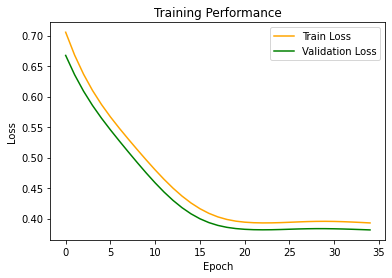

In [8]:
plt.figure()
plt.title('Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot([i for i in range(EPOCHS)], losses['train'], color='orange', label='Train Loss')
plt.plot([i for i in range(EPOCHS)], losses['val'], color='green', label='Validation Loss')
plt.legend(loc="upper right")
plt.show()

In [7]:
model_outputs = head.predict(test_scores_titles, test_scores_bodies)

In [11]:
torch.save(head.state_dict(), 'scores_head.pt')